# Introduction

Experimentation on the [Dataset for ADL Recognition with a Wrist-worn Accelerometer](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer).

In [1]:
import os
import sys
import shutil
from zipfile import ZipFile
from glob import glob
import requests
import matplotlib.pyplot as plt
import numpy as np
import sequentia as seq
import sequentia.classifiers, sequentia.preprocessing
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Import utility function for displaying results
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import show_results

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

## Downloading and deserializing the data

In [2]:
# A map of the gesture directories to their class names
directory_map = {
    'Brush_teeth': 'brush_teeth',
    'Climb_stairs*': 'climb_stairs',
    'Comb_hair': 'comb_hair',
    'Descend_stairs': 'descend_stairs',
    'Drink_glass*': 'drink_glass',
    'Eat_meat': 'eat_meat',
    'Eat_soup': 'eat_soup',
    'Getup_bed*': 'getup_bed',
    'Liedown_bed': 'liedown_bed',
    'Pour_water*': 'pour_water',
    'Sitdown_chair*': 'sitdown_chair',
    'Standup_chair*': 'standup_chair',
    'Use_telephone': 'use_telephone',
    'Walk*': 'walk'
}

classes = list(directory_map.values())

In [3]:
def file_to_numpy(file):
    """Convert acceleration parameter .txt file to np.ndarray"""
    with open(file) as f:
        X = []
        for line in f:
            Ax, Ay, Az = line.strip('\n').split()
            X.append([float(Ax), float(Ay), float(Az)])
    return np.array(X)

In [4]:
X, y = [], []
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00283/ADL_Dataset.zip'

try:
    path, zip_path = 'HMP_Dataset', 'ADL_Dataset.zip'
    print('Downloading dataset from {} ...'.format(url))
    response = requests.get(url)
    with open(zip_path, 'wb') as f:
        print('Writing {} ...'.format(zip_path))
        f.write(response.content)
    with ZipFile(zip_path, 'r') as zip_ref:
        print('Extracting {} ...'.format(zip_path))
        zip_ref.extractall()
except:
    raise
else:
    print('Reading data into Numpy arrays ...')
    for pattern, label in directory_map.items():
        for folder in glob(os.path.join(path, pattern)):
            for txt in glob(os.path.join(folder, '*.txt')):
                X.append(file_to_numpy(txt))
                y.append(label)
    print('Done!')
finally:
    os.remove(zip_path)
    shutil.rmtree(path)

Writing ADL_Dataset.zip ...
Extracting ADL_Dataset.zip ...
Reading data into Numpy arrays ...
Done!


# Dataset splits

1. Shuffle the dataset.
2. Create a 65-20-15 training, validation and test set split.

In [5]:
# Shuffle and split the data into training, validation and test sets (65-20-15)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=rng)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.43, shuffle=True, random_state=rng)

# Display the split sizes
print('Training set size: {}'.format(len(y_train)))
print('Validation set size: {}'.format(len(y_val)))
print('Test set size: {}'.format(len(y_test)))

Training set size: 636
Validation set size: 195
Test set size: 148


## Signal visualization

In [6]:
def plot_signal(signal, figsize=(7, 4), title=None):
    """Function for visualizing an accelerometer signal"""
    title = 'Accelerometer signals' if title is None else title
    labels = ['X', 'Y', 'Z']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        ax.plot(signal[:, i], label=labels[i], color=colors[i])
        ax.legend(loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0, top=0.92)
    fig.suptitle(title)
    plt.show()

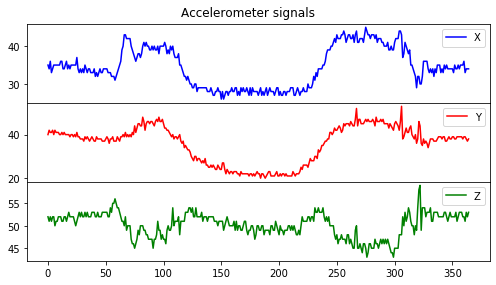

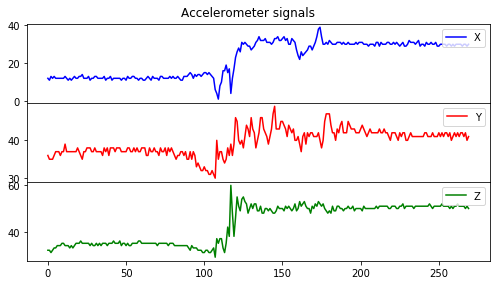

In [7]:
# Plot some sample accelerometer signals from the training set
for signal in X_train[:2]:
    plot_signal(signal)

## Approximate Dynamic Time Warping $k$-NN classifier

### Preprocessing

Classifying in the frequency domain worked better for $k$-NN.

In [8]:
# Create a preprocessing pipeline for kNN
knn_pre = seq.preprocessing.Preprocess()
knn_pre.standardize()
knn_pre.filtrate(n=5, method='median')
knn_pre.downsample(n=5, method='decimate')
knn_pre.fft()
knn_pre.summary()

          Preprocessing summary:          
1. Standardization
------------------------------------------
2. Filtering:
   Median filter with window size (n=5)
------------------------------------------
3. Downsampling:
   Decimation with downsample factor (n=5)
------------------------------------------
4. Discrete Fourier Transform


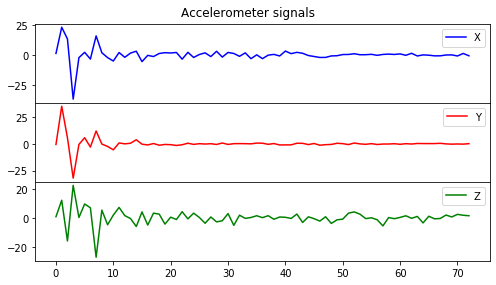

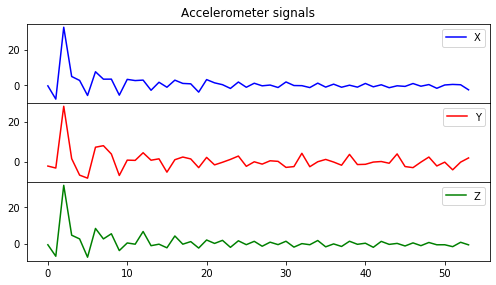

In [9]:
# Plot the same sample accelerometer signals, but preprocessed
for signal in knn_pre.transform(X_train[:2]):
    plot_signal(signal)

In [10]:
# Apply the preprocessing pipeline to each dataset split
X_train_knn, X_val_knn, X_test_knn = knn_pre.transform(X_train), knn_pre.transform(X_val), knn_pre.transform(X_test)

### Fitting the model

In [11]:
# Fit a DTWKNN classifier on the training data
clf = seq.classifiers.DTWKNN(k=1, radius=1)
clf.fit(X_train_knn, y_train)

### Evaluating the model

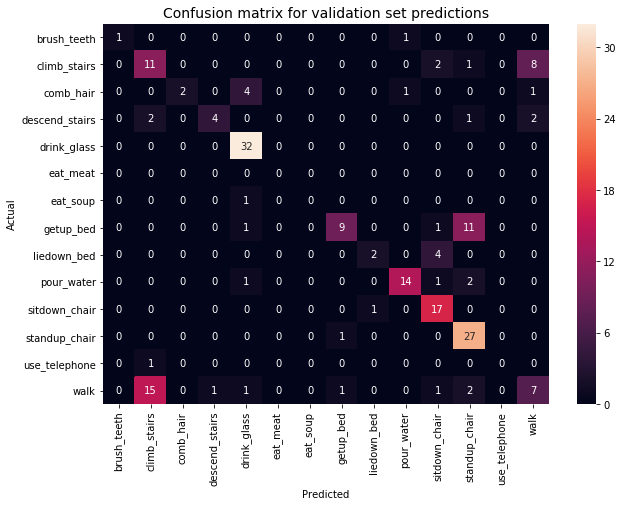

Accuracy: 64.62%
CPU times: user 1.33 s, sys: 280 ms, total: 1.61 s
Wall time: 47min 43s


In [12]:
%%time
# Classify the validation examples and display accuracy and confusion matrix
acc, cm = clf.evaluate(X_val_knn, y_val, labels=classes, n_jobs=-1)
show_results(acc, cm, dataset='validation', labels=classes)

## Hidden Markov Model classifier

### Preprocessing

In [13]:
# Create a preprocessing pipeline for HMMs
hmm_pre = seq.preprocessing.Preprocess()
hmm_pre.standardize()
hmm_pre.filtrate(n=5, method='median')
hmm_pre.downsample(n=5, method='decimate')
hmm_pre.summary()

          Preprocessing summary:          
1. Standardization
------------------------------------------
2. Filtering:
   Median filter with window size (n=5)
------------------------------------------
3. Downsampling:
   Decimation with downsample factor (n=5)


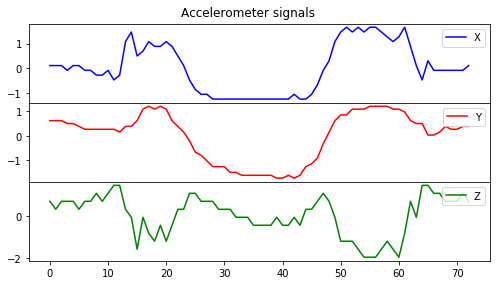

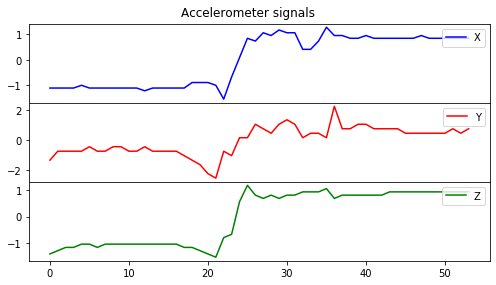

In [14]:
# Plot the same sample accelerometer signals, but preprocessed
for signal in hmm_pre.transform(X_train[:2]):
    plot_signal(signal)

In [15]:
# Apply the preprocessing pipeline to each dataset split
X_train_hmm, X_val_hmm, X_test_hmm = hmm_pre.transform(X_train), hmm_pre.transform(X_val), hmm_pre.transform(X_test)

### Fitting the model

In [18]:
%%time

# Create HMMs to represent each class
hmms = []
for c in tqdm(classes, desc='Training HMMs'):
    hmm = seq.classifiers.HMM(label=c, n_states=10, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    try:
        hmm.fit([X_train_hmm[i] for i, label in enumerate(y_train) if label == c])
    except:
        # NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
        # According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
        # - Too many states in the HMMs
        # - Too many dimensions in the input data, which leads to a large covariance matrix
        # - Too few training examples
        pass
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clf = seq.classifiers.HMMClassifier()
clf.fit(hmms)


CPU times: user 33.9 s, sys: 326 ms, total: 34.2 s
Wall time: 36.6 s


### Evaluating the model

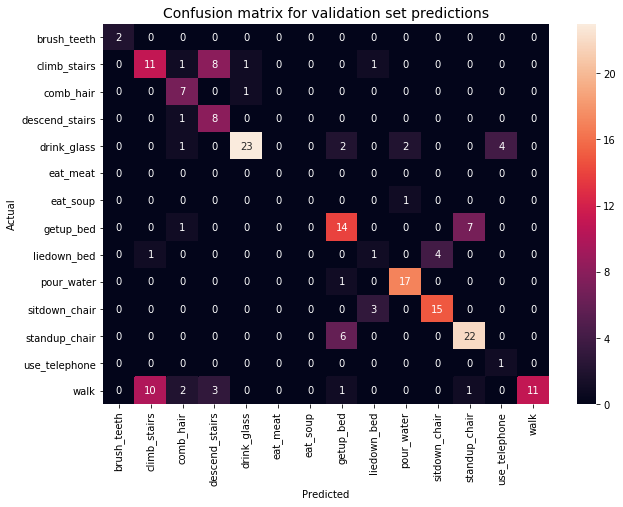

Accuracy: 67.69%
CPU times: user 2.12 s, sys: 105 ms, total: 2.22 s
Wall time: 2.32 s


In [19]:
%%time
# Classify the validation examples and display accuracy and confusion matrix
acc, cm = clf.evaluate(X_val_hmm, y_val, labels=classes)
show_results(acc, cm, dataset='validation', labels=classes)